In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [21]:
import yfinance as yf
import pandas as pd

# -----------------------------
# CONFIGURACIÓN
# -----------------------------
tickers = ['SAN.MC', 'BBVA.MC']
period = 'max'
interval = '1d'

# -----------------------------
# DESCARGAR DATOS
# -----------------------------
# auto_adjust=False para que Close sea el precio real
data = yf.download(tickers, period=period, interval=interval, auto_adjust=False)

# -----------------------------
# FUNCIONES AUXILIARES
# -----------------------------
def add_features(df):
    # Rango diario
    df['range'] = df['high'] - df['low']
    
    # Retornos diarios
    df['return'] = df['close'].pct_change()
    
    # SMA 5 y 10 días
    df['sma_5'] = df['close'].rolling(window=5).mean()
    df['sma_10'] = df['close'].rolling(window=10).mean()
    
    # Volumen relativo (comparado con media de 10 días)
    df['vol_rel'] = df['volume'] / df['volume'].rolling(window=10).mean()
    
    # Solo eliminar filas donde Close sea NaN (no por rolling)
    df = df[df['close'].notna()]
    
    return df

# -----------------------------
# PROCESAR Y GUARDAR POR TICKER
# -----------------------------
for ticker in tickers:
    # Seleccionar columnas de cada ticker usando xs
    df = data.xs(ticker, level=1, axis=1).copy()
    
    # Renombrar columnas a minúsculas
    df.columns = [col.lower() for col in df.columns]
    
    # Añadir features adicionales
    df = add_features(df)
    
    # Guardar CSV
    df.to_csv(f'{ticker.replace(".MC","")}_features.csv')
    print(f'CSV generado: {ticker.replace(".MC","")}_features.csv')


[*********************100%***********************]  2 of 2 completed

CSV generado: SAN_features.csv
CSV generado: BBVA_features.csv


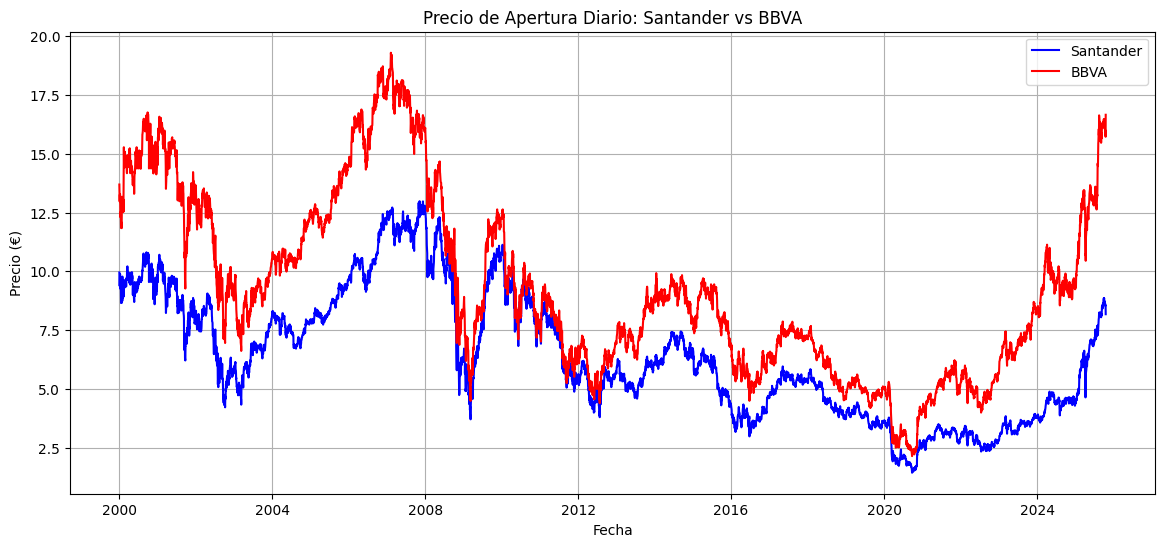

In [22]:
# Cargar CSV
df_san = pd.read_csv('..\data\csv\SAN_features.csv', index_col=0, parse_dates=True)
df_bbva = pd.read_csv('..\data\csv\BBVA_features.csv', index_col=0, parse_dates=True)

# Graficar precio de apertura
plt.figure(figsize=(14,6))
plt.plot(df_san.index, df_san['open'], label='Santander', color='blue')
plt.plot(df_bbva.index, df_bbva['open'], label='BBVA', color='red')

plt.title('Precio de Apertura Diario: Santander vs BBVA')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.legend()
plt.grid(True)
plt.show()


In [28]:


# Cargar CSV
df_san = pd.read_csv('..\\data\\csv\\SAN_features.csv', index_col=0, parse_dates=True)
df_bbva = pd.read_csv('..\\data\\csv\\BBVA_features.csv', index_col=0, parse_dates=True)

# Eliminar filas con NaN
df_san = df_san.dropna()
df_bbva = df_bbva.dropna()

# Seleccionar solo valores numéricos
features_san = df_san.values
features_bbva = df_bbva.values

# Normalizar
scaler_san = MinMaxScaler()
features_san_scaled = scaler_san.fit_transform(features_san)

scaler_bbva = MinMaxScaler()
features_bbva_scaled = scaler_bbva.fit_transform(features_bbva)

# Comprobación rápida
print("SAN min/max:", np.min(features_san_scaled), np.max(features_san_scaled))
print("BBVA min/max:", np.min(features_bbva_scaled), np.max(features_bbva_scaled))


SAN min/max: 0.0 1.0000000000000002
BBVA min/max: 0.0 1.0000000000000002


In [29]:
# -----------------------------
# Crear dataset: X = features del día, y = close del siguiente día
# -----------------------------
def create_dataset(features, target_col_index=-3):  # Ajusta target_col_index según tu CSV
    X, y = [], []
    for i in range(len(features)-1):
        X.append(features[i])
        y.append(features[i+1][target_col_index])  # cierre del siguiente día
    return np.array(X), np.array(y).reshape(-1,1)

X_san, y_san = create_dataset(features_san_scaled)
X_bbva, y_bbva = create_dataset(features_bbva_scaled)

# -----------------------------
# Convertir a tensores y pasar a GPU
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_san_t = torch.tensor(X_san, dtype=torch.float32).to(device)
y_san_t = torch.tensor(y_san, dtype=torch.float32).to(device)

X_bbva_t = torch.tensor(X_bbva, dtype=torch.float32).to(device)
y_bbva_t = torch.tensor(y_bbva, dtype=torch.float32).to(device)

# -----------------------------
# Dataset y DataLoader
# -----------------------------
batch_size = 64

san_dataset = TensorDataset(X_san_t, y_san_t)
bbva_dataset = TensorDataset(X_bbva_t, y_bbva_t)

san_loader = DataLoader(san_dataset, batch_size=batch_size, shuffle=True)
bbva_loader = DataLoader(bbva_dataset, batch_size=batch_size, shuffle=True)

# -----------------------------
# Modelo denso
# -----------------------------
class DenseModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(DenseModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

input_dim = X_san_t.shape[1]  # número de features
model_san = DenseModel(input_dim).to(device)
model_bbva = DenseModel(input_dim).to(device)

# -----------------------------
# Entrenamiento
# -----------------------------
criterion = nn.MSELoss()
optimizer_san = optim.Adam(model_san.parameters(), lr=0.001)
optimizer_bbva = optim.Adam(model_bbva.parameters(), lr=0.001)

num_epochs = 500  # muchos epochs

for epoch in range(1, num_epochs+1):
    # --- Entrenamiento Santander ---
    epoch_loss_san = 0
    for xb, yb in san_loader:
        optimizer_san.zero_grad()
        output = model_san(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer_san.step()
        epoch_loss_san += loss.item() * xb.size(0)
    epoch_loss_san /= len(san_loader.dataset)
    
    # --- Entrenamiento BBVA ---
    epoch_loss_bbva = 0
    for xb, yb in bbva_loader:
        optimizer_bbva.zero_grad()
        output = model_bbva(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer_bbva.step()
        epoch_loss_bbva += loss.item() * xb.size(0)
    epoch_loss_bbva /= len(bbva_loader.dataset)
    
    # Mostrar pérdida en cada epoch
    print(f"Epoch {epoch}/{num_epochs} - Loss SAN: {epoch_loss_san:.6f}, Loss BBVA: {epoch_loss_bbva:.6f}")


Epoch 1/500 - Loss SAN: 0.014597, Loss BBVA: 0.017186
Epoch 2/500 - Loss SAN: 0.000044, Loss BBVA: 0.000038
Epoch 3/500 - Loss SAN: 0.000027, Loss BBVA: 0.000026
Epoch 4/500 - Loss SAN: 0.000025, Loss BBVA: 0.000022
Epoch 5/500 - Loss SAN: 0.000022, Loss BBVA: 0.000021
Epoch 6/500 - Loss SAN: 0.000022, Loss BBVA: 0.000019
Epoch 7/500 - Loss SAN: 0.000021, Loss BBVA: 0.000019
Epoch 8/500 - Loss SAN: 0.000022, Loss BBVA: 0.000018
Epoch 9/500 - Loss SAN: 0.000021, Loss BBVA: 0.000018
Epoch 10/500 - Loss SAN: 0.000020, Loss BBVA: 0.000018
Epoch 11/500 - Loss SAN: 0.000018, Loss BBVA: 0.000018
Epoch 12/500 - Loss SAN: 0.000018, Loss BBVA: 0.000017
Epoch 13/500 - Loss SAN: 0.000018, Loss BBVA: 0.000018
Epoch 14/500 - Loss SAN: 0.000019, Loss BBVA: 0.000017
Epoch 15/500 - Loss SAN: 0.000018, Loss BBVA: 0.000017
Epoch 16/500 - Loss SAN: 0.000017, Loss BBVA: 0.000016
Epoch 17/500 - Loss SAN: 0.000017, Loss BBVA: 0.000018
Epoch 18/500 - Loss SAN: 0.000017, Loss BBVA: 0.000016
Epoch 19/500 - Loss